### Introduction:
Classify each feature separately as an indicator of breast cancer, ask the questions:   
“Is clump thickness an indicator of breast cancer?”   
“Is marginal adhesion an indicator of breast cancer?” etc.   
To do this you should:  
ignore column Patient id number, and   
convert column Class (2 for benign, 4 for malignant) to 1/0, using a single column as X and “class” as Y.    
Finally, combine all the classes together and do the classification. 
Make a single ROC plot.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

url_pre = 'https://archive.ics.uci.edu/ml/machine-learning-databases/'
url_pos = 'breast-cancer-wisconsin/breast-cancer-wisconsin.data'
url = url_pre + url_pos

columns = ['patient_id', 'clump_thickness', 'uni_cell_size', 'uni_cell_shape', 
           'marginal_adhesion', 'epithelial_cell_size', 'bare_nuclei', 'bland_chromatin',
           'normal_nucleoli', 'mitoses', 'class']

X = pd.read_csv(url, names=columns)

### Inspect the Raw Dataset
The datset is comprised of 11 columns in which all but 1 are numerical.  
Why bare_nuclei, indicating the proportion of the number of cells not surrounded by cytoplasm to those that are, is not of numerical but object type?

In [2]:
X.sample(5)

,patient_id,clump_thickness,uni_cell_size,uni_cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
137,1182410,3,1,1,1,2,1,1,1,1,2
10,1035283,1,1,1,1,1,1,3,1,1,2
313,693702,1,1,1,1,2,1,1,1,1,2
237,1241679,9,8,8,5,6,2,4,10,4,4
531,867392,4,2,2,1,2,1,2,1,1,2


In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   patient_id            699 non-null    int64 
 1   clump_thickness       699 non-null    int64 
 2   uni_cell_size         699 non-null    int64 
 3   uni_cell_shape        699 non-null    int64 
 4   marginal_adhesion     699 non-null    int64 
 5   epithelial_cell_size  699 non-null    int64 
 6   bare_nuclei           699 non-null    object
 7   bland_chromatin       699 non-null    int64 
 8   normal_nucleoli       699 non-null    int64 
 9   mitoses               699 non-null    int64 
 10  class                 699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


### Data Cleaning Process:
##### The reason bare_nuclei is object type is that it has 16 value of '?'.
We need to address this issue by imputing reasonable values to replace these '?'.

In [4]:
X.bare_nuclei.value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

#### Strategy to impute the missing values in bare_nuclei:
1. Find how many in each class of 2 and 4 coming with integers
2. Compute the mean values of bare nuclei in each class
3. Impute the mean values to each of bare nuclei that has missing value according to its class

In [5]:
# 1. Find how many in each class of 2 and 4 coming with numerical values
print("Distribution of Class with bare nuclei not being '?'")
print(X[X['bare_nuclei'] != '?']['class'].value_counts())

bare_nuclei_2 = X[(X['bare_nuclei'] != '?') & (X['class'] == 2)]['bare_nuclei']
bare_nuclei_4 = X[(X['bare_nuclei'] != '?') & (X['class'] == 4)]['bare_nuclei']

# Check the statistics of colums bare_nuclei with integers
print('\n' + '*-' * 20)
print(bare_nuclei_2.astype('float').describe())
print('\n' + '*-' * 20)
print(bare_nuclei_4.astype('float').describe())

# 2. Compute the mean values of bare nuclei in each class
mean_bare_nuclei_2 = round(bare_nuclei_2.astype('float').mean())
mean_bare_nuclei_4 = round(bare_nuclei_4.astype('float').mean())
print('\n' + '*-' * 20)
print('the mean of bare nuclei with class 2:', mean_bare_nuclei_2)
print('the mean of bare nuclei with class 4:', mean_bare_nuclei_4)

# Find how many in each class of 2 and 4 coming with '?'
print('\n' + '*-' * 20)
print("Distribution of Class with bare nuclei being '?'")
print(X[X['bare_nuclei'] == '?']['class'].value_counts())

Distribution of Class with bare nuclei not being '?'
2    444
4    239
Name: class, dtype: int64

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
count    444.000000
mean       1.346847
std        1.177848
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       10.000000
Name: bare_nuclei, dtype: float64

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
count    239.000000
mean       7.627615
std        3.116679
min        1.000000
25%        5.000000
50%       10.000000
75%       10.000000
max       10.000000
Name: bare_nuclei, dtype: float64

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
the mean of bare nuclei with class 2: 1
the mean of bare nuclei with class 4: 8

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Distribution of Class with bare nuclei being '?'
2    14
4     2
Name: class, dtype: int64


In [6]:
# 3. Impute the mean values to each of bare nuclei that has missing value according to its class
X.loc[(X['bare_nuclei'] == '?') & (X['class'] == 2)] = '1'
X.loc[(X['bare_nuclei'] == '?') & (X['class'] == 4)] = '8'

In [7]:
# Double check the values of column bare_nuclei
X.bare_nuclei.value_counts()

1     416
10    132
2      30
5      30
3      28
8      23
4      19
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

In [8]:
# Label the dataset and double check its  value counts
X['class'] = X['class'].apply(lambda c: 0 if c == 2 else 1)
X['class'].value_counts()

0    444
1    255
Name: class, dtype: int64

### Sanity Check of the Dataset

In [9]:
# Run the information of all columns in the dataset
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   patient_id            699 non-null    object
 1   clump_thickness       699 non-null    object
 2   uni_cell_size         699 non-null    object
 3   uni_cell_shape        699 non-null    object
 4   marginal_adhesion     699 non-null    object
 5   epithelial_cell_size  699 non-null    object
 6   bare_nuclei           699 non-null    object
 7   bland_chromatin       699 non-null    object
 8   normal_nucleoli       699 non-null    object
 9   mitoses               699 non-null    object
 10  class                 699 non-null    int64 
dtypes: int64(1), object(10)
memory usage: 60.2+ KB


In [10]:
# Convert data type of all columns to float
X = X.astype('int')

In [11]:
# Double check the information of all columns in the dataset
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   patient_id            699 non-null    int64
 1   clump_thickness       699 non-null    int64
 2   uni_cell_size         699 non-null    int64
 3   uni_cell_shape        699 non-null    int64
 4   marginal_adhesion     699 non-null    int64
 5   epithelial_cell_size  699 non-null    int64
 6   bare_nuclei           699 non-null    int64
 7   bland_chromatin       699 non-null    int64
 8   normal_nucleoli       699 non-null    int64
 9   mitoses               699 non-null    int64
 10  class                 699 non-null    int64
dtypes: int64(11)
memory usage: 60.2 KB


In [12]:
# View a sample of 10 observations in the dataset
X.sample(10)

,patient_id,clump_thickness,uni_cell_size,uni_cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
457,1259008,8,8,9,6,6,3,10,10,1,1
682,1371920,5,1,1,1,2,1,3,2,1,0
7,1018561,2,1,2,1,2,1,3,1,1,0
535,1061990,1,1,3,2,2,1,3,1,1,0
100,1166654,10,3,5,1,10,5,3,10,2,1
640,1285722,4,1,1,3,2,1,1,1,1,0
650,1319609,3,1,1,2,3,4,1,1,1,0
329,760239,10,4,6,4,5,10,7,1,1,1
353,850831,2,7,10,10,7,10,4,9,4,1
178,1202125,4,1,1,1,2,1,3,1,1,0


In [13]:
# Check the statistics of all columns
X.describe()

,patient_id,clump_thickness,uni_cell_size,uni_cell_shape,marginal_adhesion,epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.052074e+06,4.383405,3.121602,3.184549,2.808298,3.203147,3.506438,3.409156,2.846924,1.609442,0.364807
std,6.342994e+05,2.836330,3.055988,2.981604,2.856730,2.234515,3.627482,2.457950,3.041410,1.748670,0.481721
min,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,8.466275e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,1.168736e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,1.237848e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,4.500000,3.500000,1.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


### Exploratory Data Analysis of the Dataset

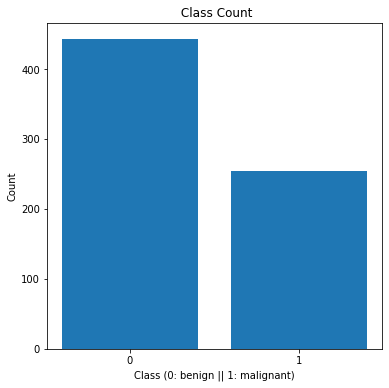

In [14]:
label_class = X['class'].value_counts()

# Visualize labels distribution
plt.bar(label_class.index, label_class)
plt.xticks([0, 1])
plt.title(' Class Count')
plt.xlabel('Class (0: benign || 1: malignant)')
plt.ylabel('Count')
plt.gcf().set_size_inches(6, 6)
plt.show()

In [15]:
features = X.columns.to_list()[1:-1]
features

['clump_thickness',
 'uni_cell_size',
 'uni_cell_shape',
 'marginal_adhesion',
 'epithelial_cell_size',
 'bare_nuclei',
 'bland_chromatin',
 'normal_nucleoli',
 'mitoses']

<Figure size 432x288 with 0 Axes>

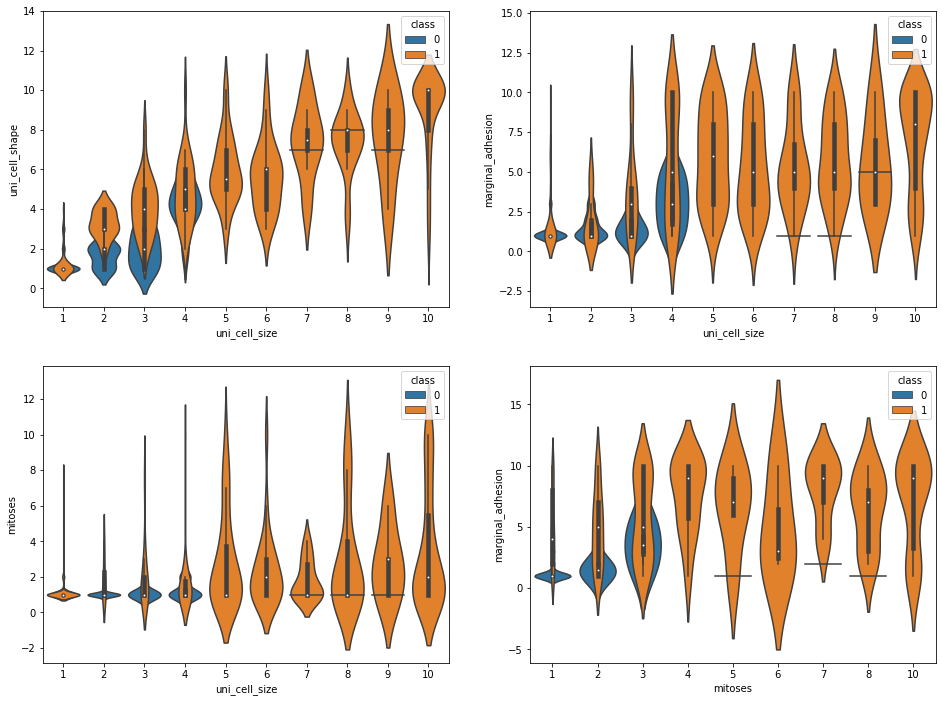

In [41]:
plt.clf()
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.violinplot(data=X, x='uni_cell_size', y='uni_cell_shape',    hue='class', dodge=False, ax = axes[0][0])
sns.violinplot(data=X, x='uni_cell_size', y='marginal_adhesion', hue='class', dodge=False, ax = axes[0][1])
sns.violinplot(data=X, x='uni_cell_size', y='mitoses',   hue='class', dodge=False, ax = axes[1][0])
sns.violinplot(data=X, x='mitoses', y='marginal_adhesion', hue='class', dodge=False, ax = axes[1][1])

In [17]:
X.uni_cell_size.value_counts()

1     387
10     67
3      52
2      45
4      38
8      30
5      30
6      25
7      19
9       6
Name: uni_cell_size, dtype: int64

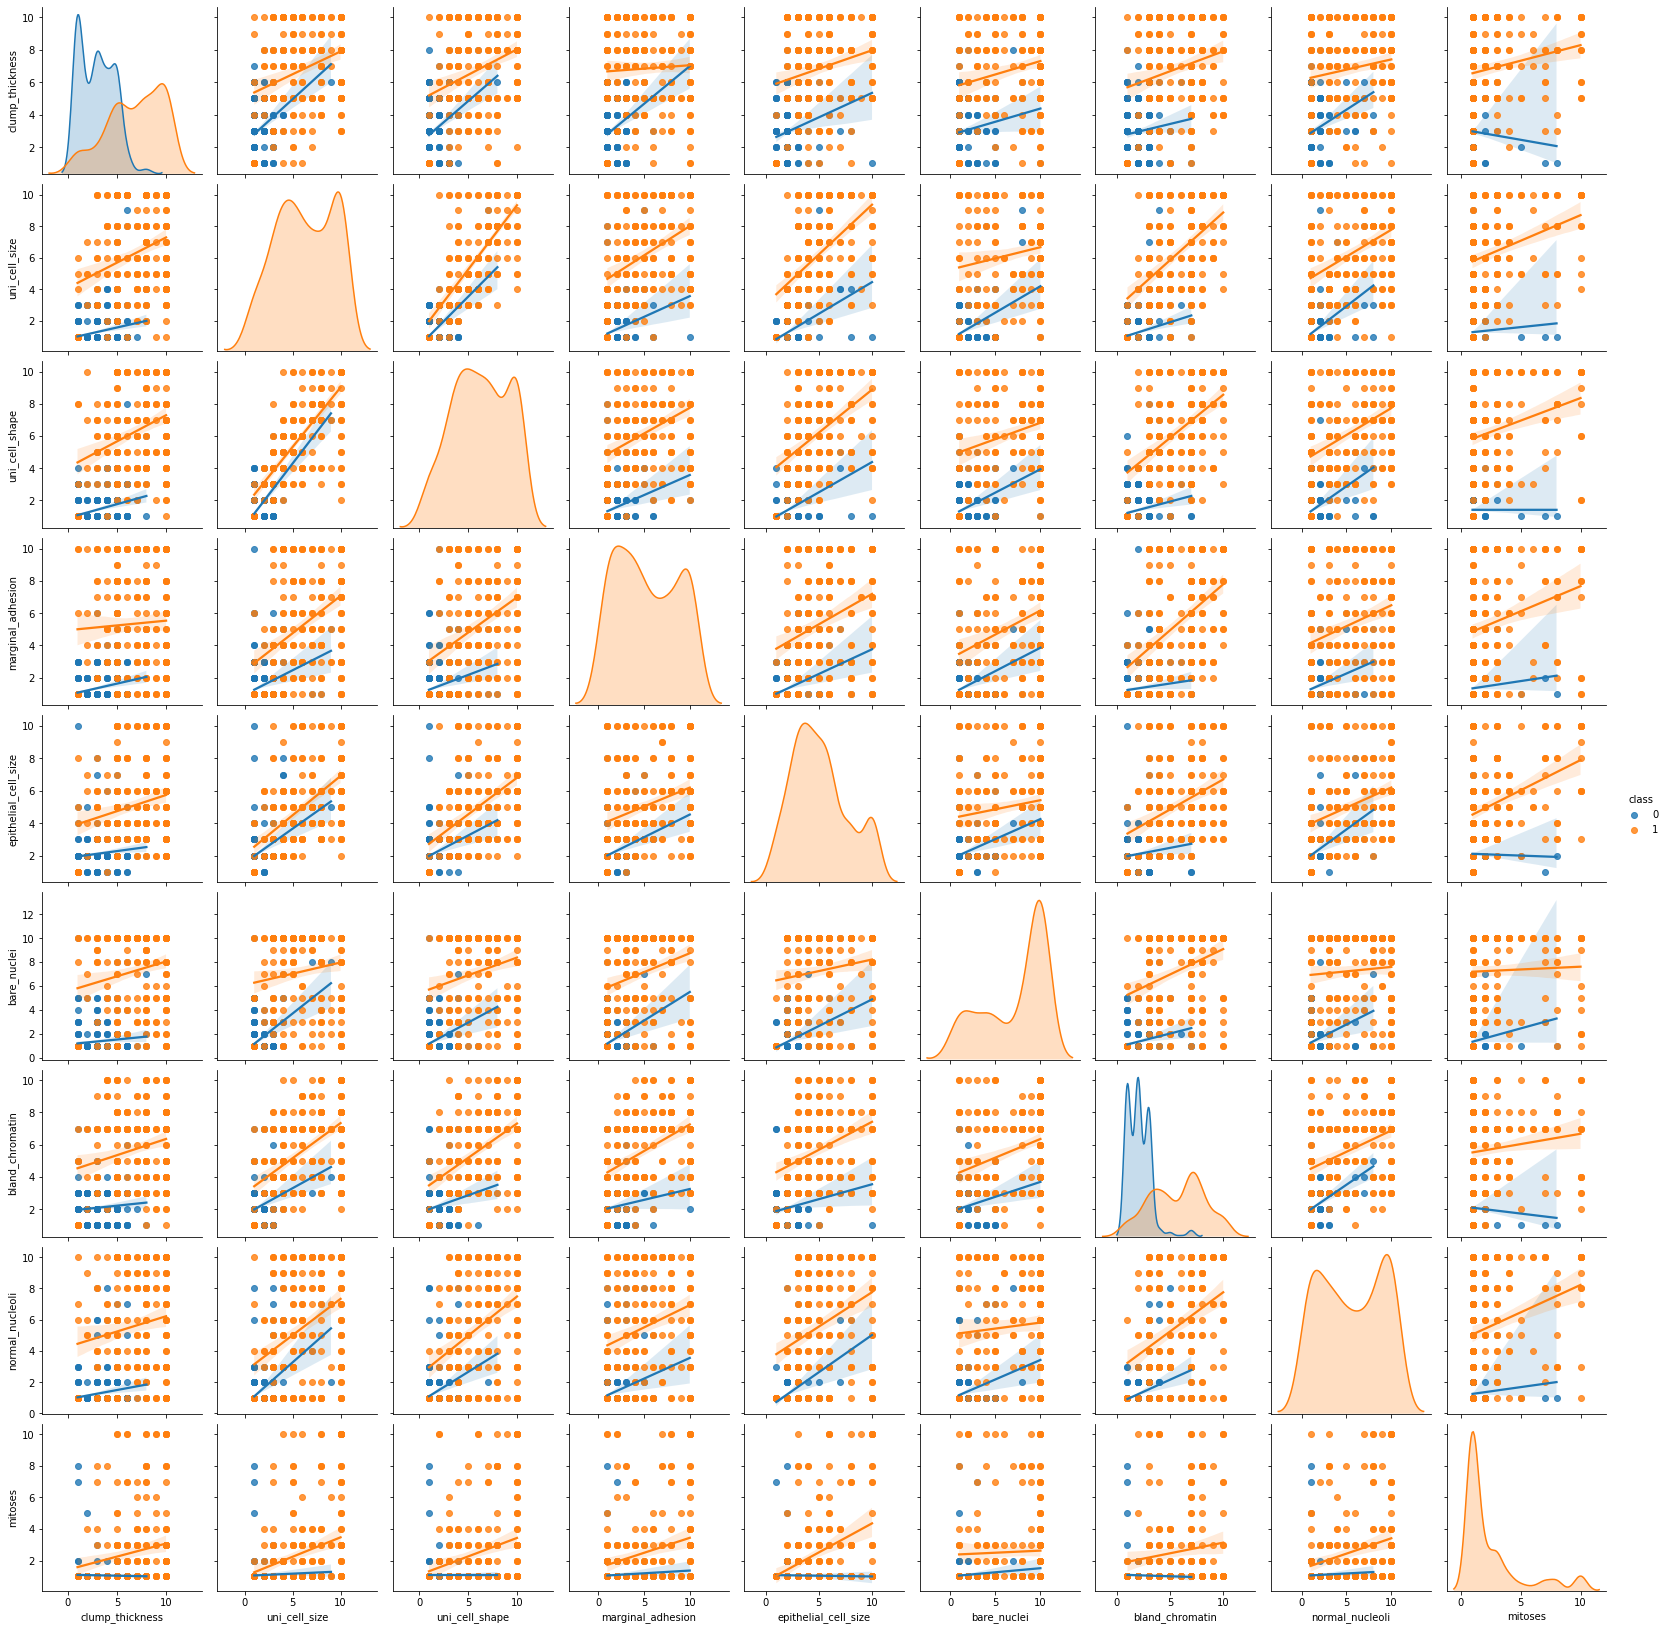

In [46]:
import warnings
warnings.filterwarnings('ignore')
sns.pairplot(data=X, vars=features, kind='reg', hue='class')

221

In [ ]:
['clump_thickness',
 'uni_cell_size',
 'uni_cell_shape',
 'marginal_adhesion',
 'epithelial_cell_size',
 'bare_nuclei',
 'bland_chromatin',
 'normal_nucleoli',
 'mitoses']